In [1]:
% matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import math
import gym

from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Environment

#### Noisy Cart Pole

This is the noisy version of the CartPole-v0 environment of OpenAI.  
https://gym.openai.com/envs/CartPole-v0  
https://github.com/openai/gym/wiki/CartPole-v0  


In [2]:
class Environment:
    
    def __init__(self, stateDimension, actionDimension, actionSpace, reset, step):
        self.stateDimension = stateDimension
        self.actionDimension = actionDimension
        self.actionSpace = actionSpace
        self.reset = reset
        self.step = step

In [3]:
class NoisyCartPole:

    stateDimension = 4
    actionDimension = 1
    transitionSigmas = [ 0.01, 0, 0.01, 0 ]
    alreadyFinished = False
    
    def __init__(self):
        self.openAI = gym.make('CartPole-v0')
        
    def reset(self):
        self.alreadyFinished = False
        return self.openAI.reset()

    def step(self, state, action):
        
        if self.alreadyFinished:
            # Zero reward till the end of the episode if pole is already dropped
            return state, 0, True, None
        
        else:
            # OpenAI Step
            next_state, reward, self.alreadyFinished, info = self.openAI.step(int(action))
            # Adding Noise 
            next_state += np.random.randn(self.stateDimension) * self.transitionSigmas
            
            return next_state, reward, self.alreadyFinished, info


### System Dynamics

In [4]:
def cartpole_reset():
    state = np.random.uniform(low=-0.05, high=0.05, size=(4,))
    return np.array(state)

In [5]:
# Extracted from OpenAI environment CartPole-v0
def cartpole_step(state, action):
    
    gravity = 9.8
    masscart = 1.0
    masspole = 0.1
    total_mass = (masspole + masscart)
    length = 0.5 # actually half the pole's length
    polemass_length = (masspole * length)
    force_mag = 10.0
    tau = 0.02  # seconds between state updates

    # Angle at which to fail the episode
    theta_threshold_radians = 12 * 2 * math.pi / 360
    x_threshold = 2.4
    
    x, x_dot, theta, theta_dot = state
    
    already_done =  x < -x_threshold \
        or x > x_threshold \
        or theta < -theta_threshold_radians \
        or theta > theta_threshold_radians
    already_done = bool(already_done)
    
    if already_done:
        
        next_state = state
        reward = 0
        done = True
        
    else:
        
        force = force_mag if action==1 else -force_mag
        costheta = math.cos(theta)
        sintheta = math.sin(theta)
        temp = (force + polemass_length * theta_dot * theta_dot * sintheta) / total_mass
        thetaacc = (gravity * sintheta - costheta* temp) / (length * (4.0/3.0 - masspole * costheta * costheta / total_mass))
        xacc  = temp - polemass_length * thetaacc * costheta / total_mass
        x  = x + tau * x_dot
        x_dot = x_dot + tau * xacc
        theta = theta + tau * theta_dot
        theta_dot = theta_dot + tau * thetaacc
        next_state = np.array([x,x_dot,theta,theta_dot])
        
        reward = 1
        
        done =  x < -x_threshold \
            or x > x_threshold \
            or theta < -theta_threshold_radians \
            or theta > theta_threshold_radians
        done = bool(done)
    
    return next_state, reward, done, {}

In [6]:
def noisycartpole_reset():
    return cartpole_reset()

In [7]:
def noisycartpole_step(state, action):
    
    transitionSigmas = [ 0.01, 0, 0.01, 0 ]
    
    next_state, reward, done, info = cartpole_step(state, action)   # CartPole Step
    
    if not done:
        next_state += np.random.randn(4) * transitionSigmas        # Adding Noise 

    return next_state, reward, done, info

In [8]:
env = Environment(4,1,range(2),noisycartpole_reset, noisycartpole_step)

# Utility Functions

In [9]:
def trajectory2tuples(states, actions):

    # Dimensions
    [sample_count, horizon, state_dimension] = states.shape
    [_, _, action_dimension] = actions.shape

    # Reshape Inputs and Targets
    inputs = np.reshape(states, (sample_count*horizon, state_dimension))
    targets = np.reshape(actions, (sample_count*horizon, action_dimension))

    return inputs, targets

In [10]:
def plot_trajectories(states, color='red', n=0):

    [sample_count, _, _] = states.shape

    if n==0:
        samples_drawn = range(sample_count)
    else:
        samples_drawn = np.random.choice(sample_count, n)
        
    for s in samples_drawn:
        plt.plot(states[s, :, 0], states[s, :, 2], '-', color=color)
        plt.plot(states[s, :, 0], states[s, :, 2], 'o', color=color, markersize=2)
        plt.plot(states[s, -1, 0], states[s, -1, 2], 'o', color=color, markersize=5)

In [11]:
def plot_iteration(states, selected=None, n=0):
    plot_trajectories(states, color='red', n=n)
    if selected is not None:
        plot_trajectories(selected, color='green', n=n)
    
    plt.vlines(0, -0.25, 0.25, linestyle='dotted')
    # plt.vlines(2.4, -0.25, 0.25, linestyle='dotted')
    # plt.vlines(-2.4, -0.25, 0.25, linestyle='dotted')
    
    plt.hlines(0, -2.4, 2.4, linestyle='dotted')
    plt.hlines(0.21, -2.4, 2.4, linestyle='dotted')
    plt.hlines(-0.21, -2.4, 2.4, linestyle='dotted')
    
    plt.grid()
    plt.show()

In [12]:
def rollout_trajectories(env, policy, horizon, sample_count=1):

    # States and Actions
    states = np.zeros((sample_count, horizon, env.stateDimension))
    actions = np.zeros((sample_count, horizon, env.actionDimension))
    rewards = np.zeros((sample_count, horizon))
    
    # Sample Trajectories
    for t in range(horizon):

        # Initialization
        if t == 0:
            states[:,t,:] = [ env.reset() for i in range(sample_count) ]
        # Transition and Reward
        else:
            for s in range(sample_count):
                states[s, t, :], rewards[s,t-1], _1, _2 = env.step(states[s, t-1, :], actions[s, t-1, :])
        
        actions[:,t,:] = policy.query(states[:, t, :]).reshape(sample_count, env.actionDimension)
        
    for s in range(sample_count):
        _, rewards[s, horizon-1], _1, _2 = env.step(states[s, horizon-1, :], actions[s, horizon-1, :])

    return states, actions, rewards

# Monte Carlo Sampling Method

In [13]:
def importance_sampling(states, actions, rewards, policy_sample_count=0):

    # Dimensions
    [sample_count, horizon, state_dimension] = states.shape
    [_, _, action_dimension] = actions.shape

    if policy_sample_count <= 0:
        policy_sample_count = sample_count

    # Weighting
    if sum(rewards) == 0:
        weights = np.ones(sample_count) / sample_count
    else:
        weights = rewards / sum(rewards)

    # Resampling
    index = np.random.choice(range(sample_count), size=policy_sample_count, p=weights, replace=True)

    # New Trajectories
    states_new = np.zeros((policy_sample_count, horizon, state_dimension))
    actions_new = np.zeros((policy_sample_count, horizon, action_dimension))
    for s in range(policy_sample_count):
        states_new[s] = states[index[s], :, :]
        actions_new[s] = actions[index[s], :, :]

    return [states_new, actions_new]

# Policy

In [14]:
class SciKitPolicy():

    def __init__(self):
        raise NotImplementedError()

    def query(self, states):
        if len(states.shape) == 1:
            states = states.reshape(1, -1)
        return self.method.predict(states)

    def train(self, inputs, targets):
        self.method.fit(inputs, targets)

    def m_step(self, states, actions):

        # States/Actions -> Inputs/Targets
        inputs, targets = trajectory2tuples(states, actions)

        # Train kNN
        self.train(inputs, targets.ravel())

In [15]:
class KnnPolicyDiscrete(SciKitPolicy):
    def __init__(self, k, weights='distance'):
        self.method = KNeighborsClassifier(n_neighbors=k, weights=weights, n_jobs=1)

In [16]:
class UniformPolicyDiscrete():

    def __init__(self, choices):
        self.choices = choices

    def query(self, states):
        return np.random.choice(self.choices, size=states.shape[0])

# Parameters

In [23]:
# Environment  
horizon = 100

# Inference
sampleCount = 1000
iterationCount = 50

# Policy
kNearest = 5
policy_sample_count = 100
selectedPolicy = KnnPolicyDiscrete(kNearest)

# Plot
rendering_enabled = False

# RLEMMC

In [24]:
iterationRewards = []

for i in range(iterationCount):

    if i == 0:
        iterationPolicy = UniformPolicyDiscrete(env.actionSpace)
    else:
        iterationPolicy = selectedPolicy

    [states, actions, rewards] = \
        rollout_trajectories(env, iterationPolicy, horizon, sampleCount)

    # E-Step
    [newStates, newActions] = importance_sampling(states, actions, np.sum(rewards,axis=1),\
                                policy_sample_count=policy_sample_count)

    # M-Step
    selectedPolicy.m_step(newStates, newActions)
        
    # Average Reward
    iterationRewards.append(np.mean(rewards) * horizon)
    print( f'Iteration {i+1} - Average Reward : {iterationRewards[i]}' )

Iteration 1 - Average Reward : 21.271
Iteration 2 - Average Reward : 30.898999999999997
Iteration 3 - Average Reward : 45.064
Iteration 4 - Average Reward : 55.567
Iteration 5 - Average Reward : 57.330999999999996
Iteration 6 - Average Reward : 62.139
Iteration 7 - Average Reward : 66.94099999999999
Iteration 8 - Average Reward : 65.99000000000001
Iteration 9 - Average Reward : 66.80199999999999
Iteration 10 - Average Reward : 67.38199999999999
Iteration 11 - Average Reward : 68.81
Iteration 12 - Average Reward : 69.979
Iteration 13 - Average Reward : 71.193
Iteration 14 - Average Reward : 71.41300000000001
Iteration 15 - Average Reward : 73.737
Iteration 16 - Average Reward : 72.973
Iteration 17 - Average Reward : 72.298
Iteration 18 - Average Reward : 73.42699999999999
Iteration 19 - Average Reward : 72.677
Iteration 20 - Average Reward : 72.776
Iteration 21 - Average Reward : 73.527
Iteration 22 - Average Reward : 70.949
Iteration 23 - Average Reward : 70.1
Iteration 24 - Average Re

# Plots

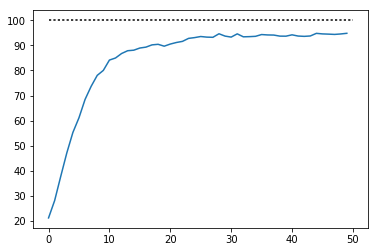

In [19]:
plt.plot(iterationRewards)
plt.hlines(np.min([horizon,195]), 0, iterationCount, linestyle='dotted')
plt.show()

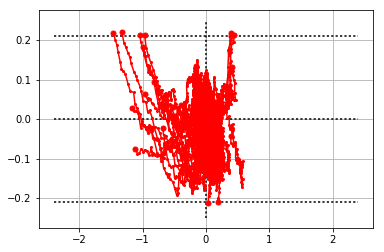

In [20]:
plot_iteration(states, n=50)

# Rendering

In [21]:
from IPython import display
def render_state(env, t):
    plt.imshow(env.render(mode='rgb_array'))
    plt.title("%s | Timestep : %s" %(env.spec.id, t))
    display.clear_output(wait=True)
    display.display(plt.gcf())

In [22]:
if rendering_enabled:
    env = gym.make('CartPole-v0')

    state = env.reset()
    for t in range(horizon):
        render_state(env,t)
        state,_,done,_ = env.step(int(iterationPolicy.query(state)))
        if done:
            break        
    render_state(env,t)

    env.render(close=True)
    plt.close()